# **Lab 5: FIR Filtering 2**

The goal of this lab is to study the response of FIR filters to inputs such as complex exponentials and sinusoids. In the experiments of this lab, you will use `np.convolve()` to implement filters and `freqz()` to obtain the filter’s frequency response. As a result, you should learn how to characterize a filter by knowing how it reacts to different frequency components in the input.
This lab also introduces two practical filters: bandpass filters and nulling filters.
Bandpass filters can be used to detect and extract information from complex signals,
e.g., tones in a touch-tone telephone dialer. Nulling filters can be used to remove
sinusoidal interference, e.g., jamming signals in a radar.

Authors:
*   Marc Bosch Manzano. U215231.
*   Arnau Balart Correa. U162432.

Delivered Date: 20/11/2024.

In [29]:
# IMPORTANT: Flags for the conditional imports
google_colab = True
authors = True

In [30]:
if (not authors) or google_colab:
    folder = 'sis1_group2/audio/'
    !git clone https://github.com/u215231/sis1_group2.git
    from sis1_group2.util import (load_audio, plot_signals, plot_spectrogram,
                      plot_mean_spectrogram, plot_frequency_response)
else:
    folder = 'audio/'
    from util import (load_audio, plot_signals, plot_spectrogram,
                      plot_mean_spectrogram, plot_frequency_response)
import os
import numpy as np
import librosa
import IPython.display as ipd
from scipy import signal
import matplotlib.pyplot as plt

fatal: destination path 'sis1_group2' already exists and is not an empty directory.


1.1. First, let's replicate what we did until now. Copy the functions synthesize and envelope and obtain the synthesis from the last lab.

In [31]:
def synthesize(f0, phi, Ak, t):
  y = 0
  for k in range(1, 9 + 1):
    y += Ak[k-1] * np.cos(2*np.pi*k*f0*t + k*phi - (k-1)*np.pi/2)
  return y

def envelope(x, N):
    if N < 1:
      raise ValueError("N must be at least 1")
    rectified_signal = np.abs(x)
    filter_coeffs = np.ones(N) / N
    envelope_signal = np.convolve(rectified_signal, filter_coeffs, mode='same')
    return envelope_signal

1.2 Plot both reference and synthesised signal.

In [32]:
# Load reference signal
filepath = folder + "piano-a4-sound.wav"
ref, fs = load_audio(filepath)

# Reference signal parameters
fs = 44100
f0 = 440
T0 = 1/f0

In [33]:
# Sample Frequency-Amplitude pairs
spectrum = np.array([
    [441.43, 0.129200],
    [882.86, 1.000000],
    [1324.3, 0.045950],
    [1771.1, 0.046560],
    [2223.3, 0.094700],
    [2675.5, 0.046840],
    [3138.5, 0.009089],
    [3601.4, 0.002395],
    [3999.8, 0.001157]
])

# Select only the sample amplitudes
weights = spectrum[:, 1]

# Create the syntethised signal
time = np.arange(0, ref.shape[0]/fs, 1.0/fs)
syn = synthesize(440, np.pi + 0.9, weights, time)

# Normalize the syntethised signal
A0 = 0.16
syn = A0 * (syn / np.max(syn))

# Add envelope to the synthesis
env = 2.0 * envelope(ref, N=1000)
syn = env * syn

In [34]:
num_periods_shown = 500
t_start = 0.15
t_end = t_start + T0*num_periods_shown

plot_signals([ref], fs, t_start=t_start, t_end=t_end, name=["Original signal"])
plot_signals([syn], fs, t_start=t_start, t_end=t_end, name=['Synthesised signal'])

---

**2. Averaging filter**

Now let's analyze the frequency response of the average filter used in the envelope function. The Scipy Python module has a function called *freqz()* for computing the frequency
response of a discrete-time LTI system. The following Python statements show how to
use freqz to compute and plot both the magnitude (absolute value) and the phase of
the frequency response of a four-point averaging system as a function of ω in the range − π ≤ ω ≤ π :

In [35]:
ww = np.arange(-np.pi, np.pi, np.pi/500)

_, HH = signal.freqz([1/4]*4, 1, ww)
plot_frequency_response(ww, HH)

For FIR filters, the second argument of `freqz(-, 1,- )` must always be equal to 1. The frequency vector ww should cover an interval of length 2π for ω , and its spacing must be fine enough to give a smooth curve for H(ejω) . Note: we will always use capital H for the frequency response.

2.1 Use the `freqz` and `plot_frequency_response` functions to plot the frequency response of the averaging filter of your envelope function.



In [36]:
N = 1000

_, HH = signal.freqz([1/N]*N, 1, ww)
plot_frequency_response(ww, HH)

2.2 Looking at the frequency responses, what are the main differences between your filter and the four-point averaging filter. What happens when the value N is increased?

As we increase the N value, the frequency response only obtains values for very low frequencies, those near to zero. In other words, since this filter smooths our signal, the highest frequencies are omitted and we only conserve the lowest frequencies.



---

**3. Nulling Filters for Rejection**

Nulling filters are filters that completely eliminate some frequency components. If the frequency is $\omega=0$ or $\omega=\pi$ then a two-point FIR filter will do the nulling. The simplest possible general nulling filter can have as few as three coefficients. If $\omega_n$ is the desired nulling frequency, then the following length-3 FIR filter

$$
y[n] = x[n] - 2\cos(\omega_n)x[n-1] + x[n-2]
$$

will have a zero in its frequency response at $\omega=\omega_n$. For example, a filter designed to completely eliminate signals of the form $e^{j0.5\pi}$ would have the following coefficients because we would pick the desired nulling frequency to be $\omega_n = 0.5\pi$

$$
b_0 = 1, \quad b1=-2cos(\omega_n)=0, \quad b_2=1
$$

3.1 Use the following function to add an interference in your reference signal. Name the corrupted signal as `x_interf`.

In [37]:
def add_interference(x, fs):
  t = np.linspace(0, len(x)*1/float(fs), len(x))
  y = x + (np.amax(x)/10)*np.sin(2*np.pi*1000*t)
  return y

In [38]:
x_interf = add_interference(ref, fs)

3.2 Plot both the reference signal and the corrupted signal and listen to the latter one.

In [39]:
plot_signals([ref], fs, t_start=t_start, t_end=t_end, name=['Reference signal'])
plot_signals([x_interf], fs, t_start=t_start, t_end=t_end, name=['Corrupted signal'])

In [40]:
ipd.Audio(x_interf, rate=fs)

In the "x_interf" signal, we can listen a high frequency that is simultaneously played as the same time as our original signal.

3.3 Compare the spectrograms of the reference signal and the interference signal.

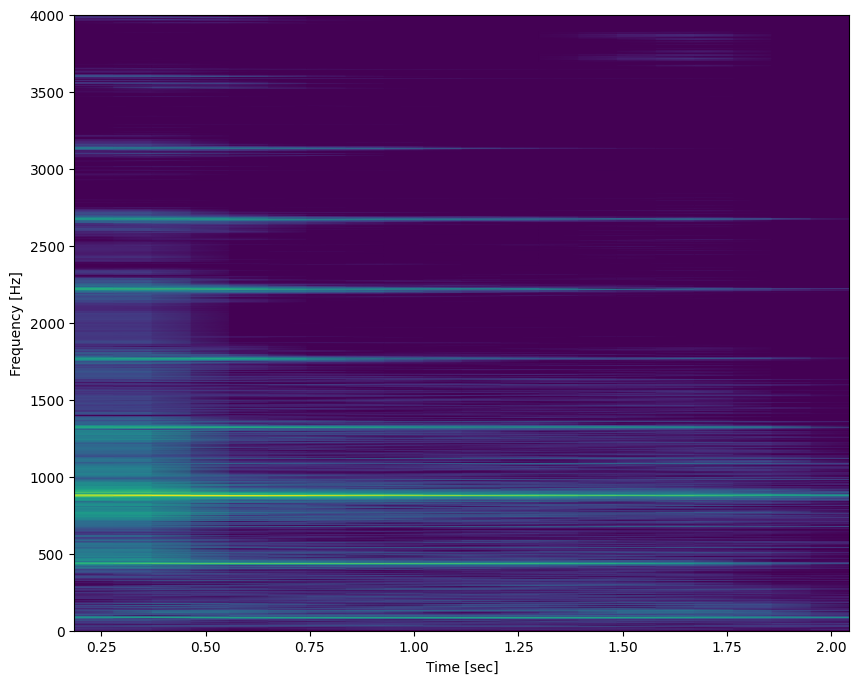

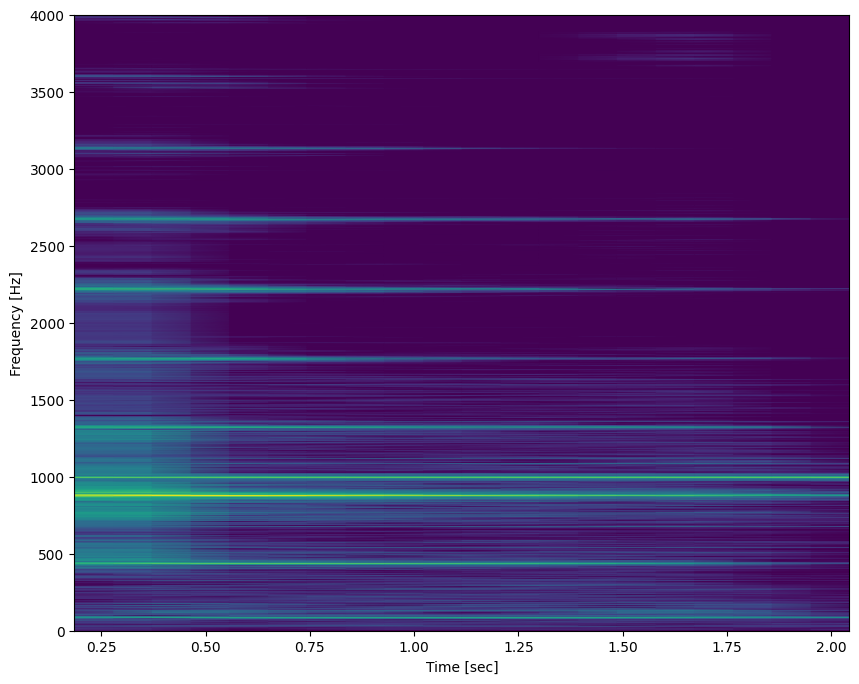

In [41]:
window_length = 8192*2
ff, tt, S = signal.spectrogram(ref, fs, nperseg=window_length, noverlap=window_length/2)
plt.figure(figsize=(10,8))
plot_spectrogram(ff, tt, S)
plt.ylim([0, 4000])
plt.show()

ff, tt, Sy = signal.spectrogram(x_interf, fs, nperseg=window_length, noverlap=window_length/2)
plt.figure(figsize=(10,8))
plot_spectrogram(ff, tt, Sy)
plt.ylim([0, 4000])
plt.show()

We can see there is a new frequential component on frquency 1000 Hz.

3.4. Create a function `remove_interference(x, fs)` that applies a nulling filter devised to remove the interference at 1000 Hz.

Note: remember that a frequency can be converted to the normalized radian frequncy by: $\hat\omega_n = 2\pi f_n/f_s$

In [42]:
def remove_interference(x, fs):
  h = [1, -2*np.cos(2*np.pi*1000/fs), 1]
  y = np.convolve(x, h, mode='same')
  return y

In [43]:
_, HH = signal.freqz([1, -2*np.cos(2*np.pi*1000/fs), 1], 1, ww)
plot_frequency_response(ww, HH)


Here, we can see the diagrams of frequency response from our filter (magnitude & phase). It shrinks all the frequencies below 1000 Hz and also some of the frequencies up to this value. We can check in that, on normalized frequency $\hat\omega_n = 2\pi f_n/f_s = 2\pi 1000/44100 \approx 0.143$, the magnitude value is $0$.

3.5 Use the `remove_interference` funcion to clean the corrupted signal,  `x_interf`. Call the output as `x_clean`. Compare the spectrograms of both signals. Explain the result.

In [44]:
x_clean = remove_interference(ref, fs)

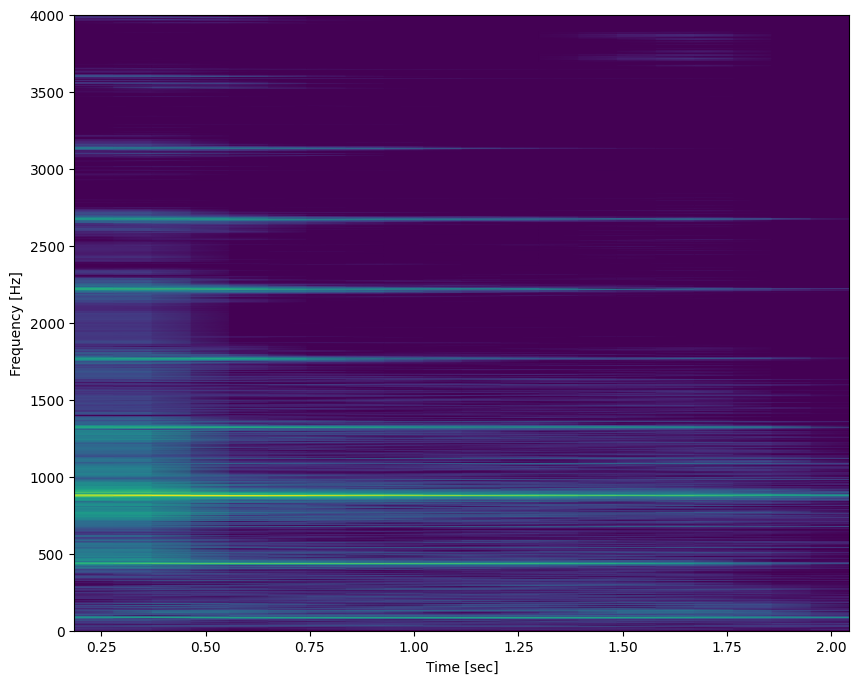

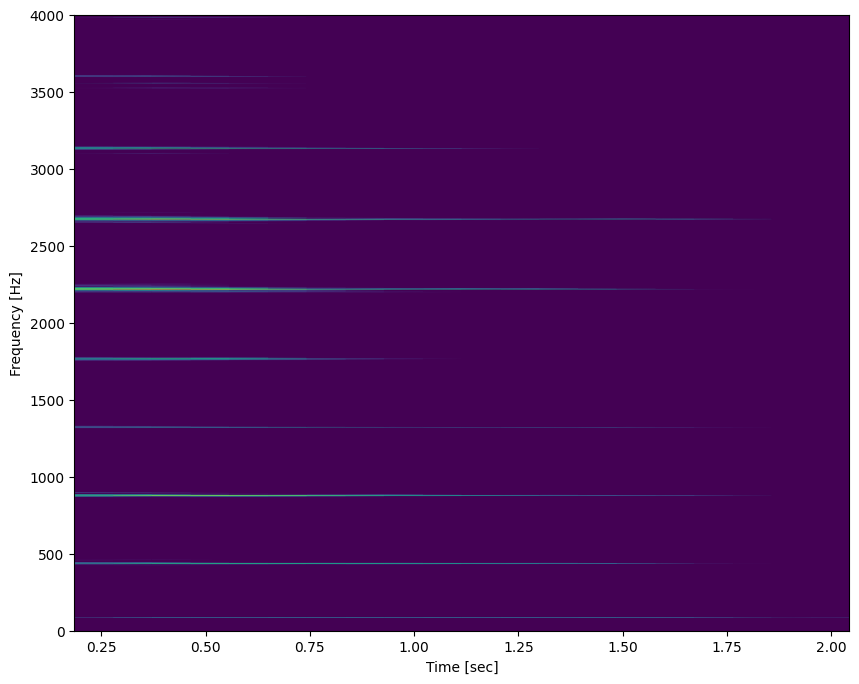

In [45]:
window_length = 8192*2
ff, tt, S = signal.spectrogram(ref, fs, nperseg=window_length, noverlap=window_length/2)
plt.figure(figsize=(10,8))
plot_spectrogram(ff, tt, S)
plt.ylim([0, 4000])
plt.show()

ff, tt, Sy = signal.spectrogram(x_clean, fs, nperseg=window_length, noverlap=window_length/2)
plt.figure(figsize=(10,8))
plot_spectrogram(ff, tt, Sy)
plt.ylim([0, 4000])
plt.show()

As positive aspects, the filter applied on our reference signal has removed the 1000 Hz frequency, which was our goal. Besides, the lower frequency noise has also been almost deleted.

As negative aspects, in the clean signal we can observe all frequencies have decreased, specially the lower ones. In addition, the high frequency noise has been incresed, which is not good.


In [46]:
ipd.Audio(x_clean, rate=fs)

As we can hear, we have deleted the 1000 Hz interference, but, as a counterpart, we have obtained an amplification of the high pitch noise.

In addition, the signal has also lost the lower frequencies. As a consequence, the audio has lost a lot of information; that's why we hear it with "low quality".